# Generative Adversarial Network (GAN) {-}

This notebook aims at familiarizing you with training, validating and testing a Generative Adversarial Network (GAN). Here are the requirements:

- Load the dataset. To save training time, you only need to load and work on ONE image class of your choice.
- Process the images.
- Build a GAN architecture consisting of at least one (01) Discriminator and one (01) Generator of which the architectures are of your choice. There are two levels of image generation requirements:
    - First-level requirement: train and generate images for ONE class of the dataset using vanilla GAN. 
    - Second-level requirement: train and generate images for ONE class of the dataset using the mechanism of ProGAN. 
- Visualize the model behaviors during the training.
- Visualize the generated images.

The dataset you will be working on is CIFAR-10. This dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

# Library and data importation

In [1]:
!pip install tensorflow_datasets

import numpy as np
from numpy import zeros, ones, vstack, expand_dims
from numpy.random import randn, randint
import matplotlib.pyplot as plt
from matplotlib import pyplot

import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.utils import np_utils
from keras import Model
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Conv2DTranspose, LeakyReLU, Reshape, Dropout, BatchNormalization, GlobalMaxPooling2D
from keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split
import os

In [2]:
# Set random seed for reproducibility
tf.random.set_seed(1234)
np.random.seed(42)

# First-level requirement
First-level requirement: train and generate images for ONE class of the dataset using vanilla GAN.

## Build the GAN with Generator & Discriminator

In [3]:
# Define the structure of Generator
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 4 * 4 * 256
    model.add(Dense(input_dim=latent_dim, units=n_nodes))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # model.add(BatchNormalization())

    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # model.add(BatchNormalization())

    model.add(Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh'))

    return model


# Show a sample of Generator structure
generator = define_generator(128)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              528384    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                              

In [4]:
# Define the structure of Discriminator
def define_discriminator(in_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

# Show a sample of Discriminator structure
sample_discriminator = define_discriminator()
sample_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)      

In [5]:
# Define the GAN network consisting of a Generator and a Discriminator
def define_gan(g_model, d_model):
    # g_model: Generator component
    # d_model: Discriminator component

    model = Sequential() # Initialize a sequential model
    model.add(g_model) # Add the Generator component
    model.add(d_model) # Add the Discriminator component
    return model # Return the GAN

## Prepare real data samples from the dataset

In [6]:
def load_real_samples():
    (trainX, trainY), (_, _) = tf.keras.datasets.cifar10.load_data()
    # Select only the images with label "8" (ship)
    idx = np.where(trainY == 8)[0]
    X = trainX[idx].astype('float32')
    X = (X - 127.5) / 127.5  # Normalize to [-1, 1]
    return X


# Select real samples from the real dataset for training purpose
def generate_real_samples(dataset, n_samples):
    # Generate random n_samples sample indices from the dataset
    ix = randint(0, dataset.shape[0], n_samples)
    # Get the images from the list of indices
    X = dataset[ix]
    # Generate labels for the real samples (label=1)
    y = ones((n_samples, 1))
    return X, y # Return the real images and labels.

## Generate fake data samples by passing a random vector through the Generator

In [7]:
# Generate random latent vectors as input for Generator
def generate_latent_points(latent_dim, n_samples):
    # Generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # Reshape to a batch of inputs for the Generator
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# Use Generator to generate n_samples fake samples
def generate_fake_samples(g_model, latent_dim, n_samples):
    # Generate random latent vectors as input for Generator
    x_input = generate_latent_points(latent_dim, n_samples)
    # Generate fake data samples by passing the random latent vectors through the Generator
    X = g_model.predict(x_input)
    # Generate labels for the fake samples (label=0)
    y = zeros((n_samples, 1))
    return X, y # Return the fake images and labels.

## Training process with the Generator and the Discriminator

In [8]:
# Train the Generator and the Discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=201, n_batch=4096):
    bat_per_epo = int(dataset.shape[0] / n_batch) # Number of iterations per epoch
    half_batch = int(n_batch / 2) # A batch to the Discriminator contains real samples (half-batch) and fake samples (half-batch)

    d_loss_values = [] # Array containing Discriminator loss over iterations
    g_loss_values = [] # Array containing Generator loss over iterations

    # Number of epochs
    for i in range(n_epochs):
        # Number of iterations
        for j in range(bat_per_epo):

            # Randomly get half_batch real data samples from the real dataset
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # Generate half_batch fake data samples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # Create training set for the discriminator: half-batch real and half-batch fake
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

            # Update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)

            # Generate random latent vectors as input for Generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # Generate inverted labels for the fake samples to train the Generator
            y_gan = ones((n_batch, 1))
            # Train the Generator
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Training log after every iteration
            print('Epoch %d, Iteration %d/%d, D_loss = %.3f, G_loss = %.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

            # Add loss values to historical arrays
            d_loss_values.append(d_loss)
            g_loss_values.append(g_loss)

        # Plot the generated images every certain number of epochs
        if (i+1) % 10 == 0:
            X_fake, _ = generate_fake_samples(g_model, latent_dim, 100) # Generate 100 fake data samples using the Generator. Pixel values are in [0,1]
            save_plot(X_fake, i, n=10) # Plot a grid of 10x10 fake samples and save to file at epoch i

    return d_loss_values, g_loss_values # Return the loss arrays of Generator and Discriminator

## Plot the Generator's output

In [9]:
# Define the directory path for saving generated images
save_dir = '/content/generated_images'

# Create and save a plot of generated images
def save_plot(samples, epoch, n=10):
    # Create directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)

    # Define a plot of (n rows, n columns)
    for i in range(n * n):
        # (1+i) is the index position on a grid with nrows rows and ncols columns. Index starts at 1 in the upper left corner and increases to the right.
        pyplot.subplot(n, n, 1+i)
        pyplot.axis('off') # Disable axis
        pyplot.imshow(samples[i, :, :, 0], cmap='gray_r') # Plot the sample i with reversed gay color map
    filename = f'Plot_epoch_{epoch+1:03d}.png'
    filepath = os.path.join(save_dir, filename)
    pyplot.savefig(filepath) # Save plot to file
    pyplot.close() # Close the plot

## Main code

In [10]:
# Size of the latent space
latent_dim = 128
epochs = 250
batch_size = 64

# Initialize an optimizer. Pick one.
opt = Adam(learning_rate=0.0002, beta_1=0.5) # Adam optimizer with customized values (for the best result)
# opt = Adam() # Adam optimizer with default values
# opt = SGD() # SGD optimizer with default values

# Create the Discriminator
d_model = define_discriminator()
d_model.trainable = True
d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Create the Generator
g_model = define_generator(latent_dim)

# Create the GAN
d_model.trainable = False
gan_model = define_gan(g_model, d_model)
gan_model.compile(loss='binary_crossentropy', optimizer=opt)

# Load real image data from the MNIST dataset
dataset = load_real_samples()

# Train the GAN
d_losses, g_losses = train(g_model, d_model, gan_model, dataset, latent_dim, epochs, batch_size)

Streaming output truncated to the last 5000 lines.
Epoch 218, Iteration 77/78, D_loss = 0.518, G_loss = 0.952
1/1 [==============================] - 0s 19ms/step
Epoch 218, Iteration 78/78, D_loss = 0.599, G_loss = 0.852
1/1 [==============================] - 0s 23ms/step
Epoch 219, Iteration 1/78, D_loss = 0.567, G_loss = 1.147
1/1 [==============================] - 0s 20ms/step
Epoch 219, Iteration 2/78, D_loss = 0.434, G_loss = 1.185
1/1 [==============================] - 0s 23ms/step
Epoch 219, Iteration 3/78, D_loss = 0.669, G_loss = 1.032
1/1 [==============================] - 0s 21ms/step
Epoch 219, Iteration 4/78, D_loss = 0.677, G_loss = 0.875
1/1 [==============================] - 0s 20ms/step
Epoch 219, Iteration 5/78, D_loss = 0.465, G_loss = 1.203
1/1 [==============================] - 0s 23ms/step
Epoch 219, Iteration 6/78, D_loss = 0.579, G_loss = 1.084
1/1 [==============================] - 0s 18ms/step
Epoch 219, Iteration 7/78, D_loss = 0.625, G_loss = 1.022
1/1 [====

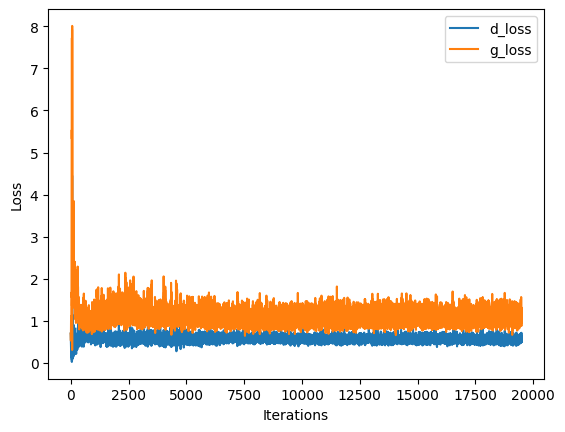

In [11]:
### Plot the training loss of the Generator and the Discriminator over iterations

# Initialize values of x-axis (iterations)
dx = np.linspace(0, len(d_losses), len(d_losses))
gx = np.linspace(0,len(g_losses), len(d_losses))

# Plot the training loss of G and D
plt.plot(dx, d_losses)
plt.plot(gx, g_losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()

## Save and load the model

In [12]:
# Save the Discriminator, Generator and GAN model
d_model.save('d_model.sav')
g_model.save('g_model.sav')
gan_model.save('gan_model.sav')

4/4 [==============================] - 0s 4ms/step


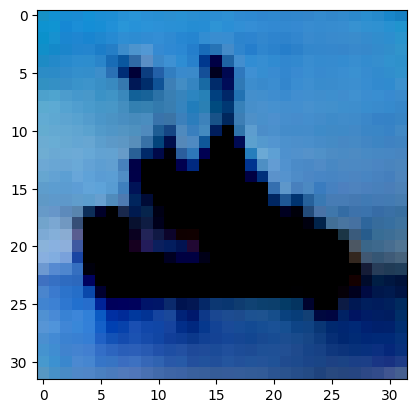

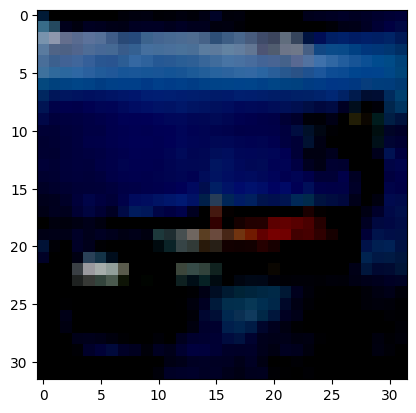

In [13]:
# Load the Generator from saved model
g_model = keras.models.load_model("g_model.sav")

# Generate 100 fake images by passing 100-dimensional random vectors through the Generator.
X_fake, _ = generate_fake_samples(g_model, 128, 100)

# Visualize the generated images
imgplot = plt.imshow(X_fake[5])
plt.show()
imgplot = plt.imshow(X_fake[10])
plt.show()

In [14]:
def visualize_images(g_model, latent_dim, n_samples):
    # Generate fake samples using the Generator
    X_fake, _ = generate_fake_samples(g_model, latent_dim, n_samples)

    # Rescale pixel values from [-1, 1] to [0, 1]
    X_fake = (X_fake + 1) / 2.0

    # Create a grid of generated images
    fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    axs = axs.flatten()

    for i in range(n_samples):
        axs[i].imshow(X_fake[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 102ms/step


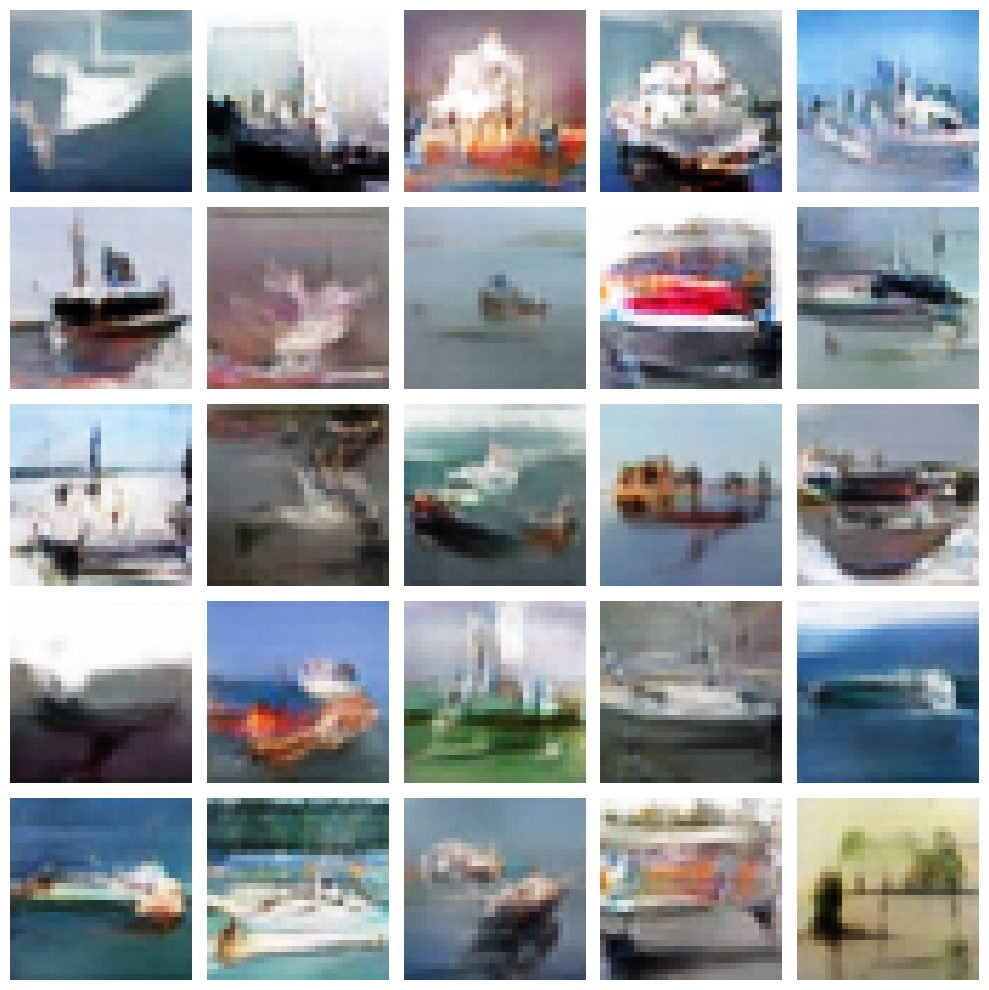

In [15]:
visualize_images(g_model, latent_dim, 25)

In [16]:
import imageio
import os

path = '/content/generated_images/'
images = []
for filename in os.listdir(path):
    if filename.endswith('.png'):
        images.append(imageio.imread(path + filename))
imageio.mimsave(path + 'output.gif', images)


<ipython-input-16-587811d88f83>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path + filename))


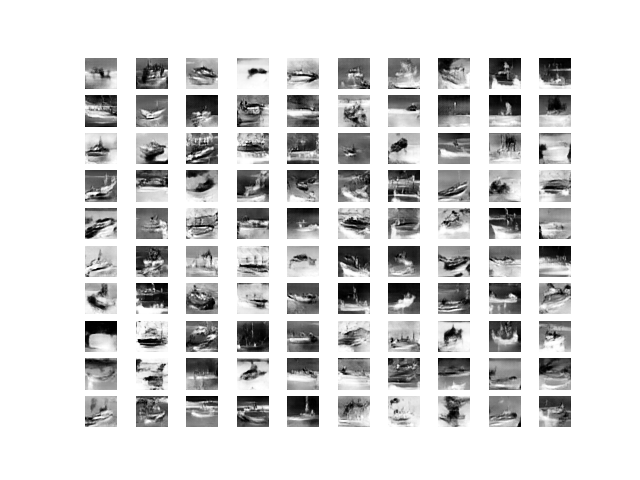

In [17]:
from IPython.display import Image
Image(filename='/content/generated_images/output.gif')